<a href="https://colab.research.google.com/github/olgasherbiena/KPI/blob/IDA/lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords, reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests, warnings, zipfile, nltk, re, os
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import kagglehub
from kagglehub import KaggleDatasetAdapter
import os

## Generate Data

In [4]:
dataset_path = kagglehub.dataset_download("albertobircoci/support-ticket-priority-dataset-50k")
support_ticket_data = pd.read_csv(os.path.join(dataset_path, "Support_tickets.csv"))

100%|██████████| 1.17M/1.17M [00:00<00:00, 51.0MB/s]

Extracting files...


In [5]:
numerical_features = ['customers_affected']
categorical_features = ['company_size_cat', 'region_cat', 'customer_tier_cat']

# Енкодинг цільової змінної
le = LabelEncoder()
y_encoded = le.fit_transform(support_ticket_data['priority_cat'])
priorities = le.classes_ # ['High', 'Low', 'Medium'] - 3 класи
num_classes = len(priorities)

# Пайплайн обробки вхідних даних
preprocessor = ColumnTransformer(
    transformers=[
        ('num',
         Pipeline([('imputer', SimpleImputer(strategy='mean')),
                   ('scaler', StandardScaler())]),
         numerical_features),
        ('cat',
         Pipeline([('encoder', OneHotEncoder(handle_unknown='ignore'))]),
         categorical_features)
    ],
    remainder='drop'
)

X = support_ticket_data[numerical_features + categorical_features].copy()
X_scaled = preprocessor.fit_transform(X)

# ВАЖЛИВО: Нейронні мережі (Dense layers) краще працюють з щільними масивами,
# а OneHotEncoder часто повертає розріджену (sparse) матрицю. Перетворимо її:
if hasattr(X_scaled, "toarray"):
    X_scaled = X_scaled.toarray()

print(f"Матриця X_scaled успішно створена. Розмірність: {X_scaled.shape}")


# --- АДАПТОВАНА ЧАСТИНА (Нейронна мережа) ---

# 1. Розділення на тренувальну та тестову вибірку
# Використовуємо ваші X_scaled та y_encoded
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 2. Перетворення цільової змінної у категоріальний вигляд (one-hot для виходу мережі)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# 3. Побудова нейронної мережі
model = Sequential([
    # input_shape береться автоматично з кількості колонок у вашому X_train
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    # Вихідний шар: кількість нейронів = кількості класів (у вас 3)
    Dense(num_classes, activation='softmax')
])

# 4. Компіляція та навчання моделі
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train_cat,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
    verbose=1
)

# 5. Оцінка результатів
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Розрахунок точності, порівнюючи передбачені класи з реальними y_test (які були закодовані LabelEncoder)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy на тестовому наборі: {test_accuracy:.4f}")

# Приклад декодування результату назад у текстовий вигляд ('High', 'Medium' тощо)
# print("Приклад передбачень:", le.inverse_transform(y_pred[:5]))

Матриця X_scaled успішно створена. Розмірність: (50000, 10)
Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.6329 - loss: 0.7804 - val_accuracy: 0.6789 - val_loss: 0.6810
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6769 - loss: 0.6950 - val_accuracy: 0.6790 - val_loss: 0.6693
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.6849 - loss: 0.6756 - val_accuracy: 0.6835 - val_loss: 0.6599
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6848 - loss: 0.6759 - val_accuracy: 0.6829 - val_loss: 0.6676
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6848 - loss: 0.6626 - val_accuracy: 0.6801 - val_loss: 0.6586
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6870 - loss: 0.6612 - val_accuracy: 0.6855 - val_loss: 0.6506
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6872 - loss: 0.6592 - val_accuracy: 0.6812 - val_loss: 0.6605
Epoch 8/100
2000/2000 

In [6]:
print(f"Точність моделі на тестовій вибірці: {test_accuracy:.4f}")
print("Детальний звіт класифікації:")
print(classification_report(y_test, y_pred))


Точність моделі на тестовій вибірці: 0.6886
Детальний звіт класифікації:
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      5033
           1       0.57      0.52      0.54      3495
           2       0.69      0.49      0.57      1472

    accuracy                           0.69     10000
   macro avg       0.67      0.62      0.64     10000
weighted avg       0.68      0.69      0.68     10000



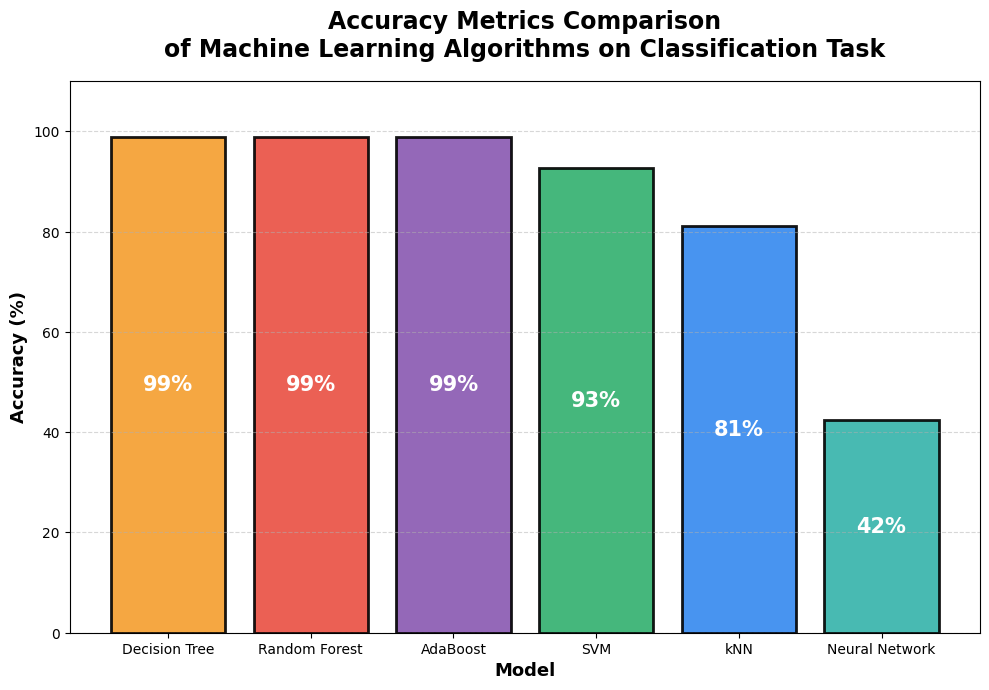

In [12]:
# Візуалізація поточного результату та результатів із першої лабораторної
all_results = {
    'kNN': 0.8111,
    'Decision Tree': 0.9889,
    'SVM': 0.9278,
    'Random Forest': 0.9889,
    'AdaBoost': 0.9889,
    'Neural Network': test_accuracy,
}

sorted_items = sorted(all_results.items(), key=lambda x: x[1], reverse=True)
labels = [x[0] for x in sorted_items]
values = [x[1] for x in sorted_items]

color_map = {
    'kNN': '#3489ef',
    'Decision Tree': '#f49e2d',
    'SVM': '#31af6e',
    'Random Forest': '#e94f41',
    'AdaBoost': '#8857b1',
    'Neural Network': '#34b3aa',
}
bar_colors = [color_map[x] for x in labels]
plt.figure(figsize=(10, 7))
bars = plt.bar(labels, [v*100 for v in values], color=bar_colors, edgecolor='black', alpha=0.90, linewidth=2)

for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height()/2,
        f"{value*100:.0f}%",
        ha='center', va='center',
        color='white',
        fontsize=15,
        fontweight='bold'
    )

plt.title('Accuracy Metrics Comparison\nof Machine Learning Algorithms on Classification Task', fontsize=17, fontweight='bold', y=1.03)
plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
plt.ylim(0, 110)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Датасет завантажено в: /root/.keras/datasets/flower_photos

Завантаження тренувальних даних:
Found 2936 images belonging to 1 classes.

Завантаження валідаційних даних:
Found 734 images belonging to 1 classes.

Класів знайдено: 1 ['flower_photos']
Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 38s 415ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 450ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.000

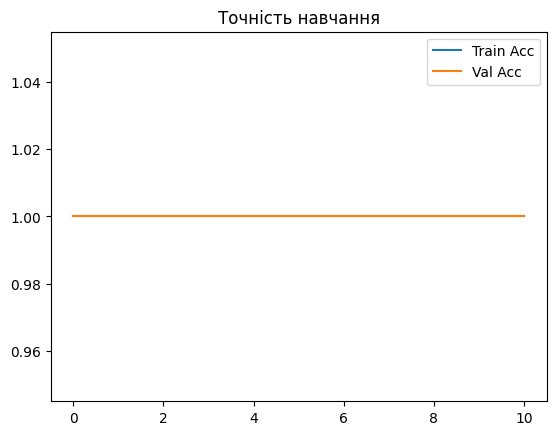

In [21]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 1. ЗАВАНТАЖЕННЯ ДАТАСЕТУ (Flowers) ---
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir_path = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir_path)

print(f"Датасет завантажено в: {data_dir}")

# --- 2. ПІДГОТОВКА ДАНИХ (Твій стиль з ImageDataGenerator) ---

# Параметри
batch_size = 32
img_height = 64  # Можна поставити 128 для кращої якості, але 64 швидше
img_width = 64

# Створення генератора з аугментацією (твої налаштування)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Нормалізація кольорів (0-1)
    rotation_range=40,          # Крутимо
    width_shift_range=0.3,      # Суваємо
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,             # Зумимо
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2        # 20% на валідацію
)

# Генератор для тренування (зчитує з папки data_dir)
print("\nЗавантаження тренувальних даних:")
train_generator = train_datagen.flow_from_directory(
    str(data_dir),              # Шлях до папки
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',          # Це важливо: вказуємо, що це train
    shuffle=True
)

# Генератор для валідації
print("\nЗавантаження валідаційних даних:")
validation_generator = train_datagen.flow_from_directory(
    str(data_dir),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',        # Вказуємо, що це validation
    shuffle=False
)

# Рахуємо кроки (як у твоєму прикладі)
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size
num_classes = len(train_generator.class_indices)

print(f"\nКласів знайдено: {num_classes} {list(train_generator.class_indices.keys())}")


# --- 3. ПОБУДОВА МОДЕЛІ (CNN) ---
# Адаптована під розмір (64, 64, 3)

model_simple = Sequential([
    # Input shape має співпадати з target_size генератора (64, 64, 3)
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # 5 класів квітів
])

model_simple.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)


# --- 4. НАВЧАННЯ ---

history_simple = model_simple.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,  # Можна змінити кількість епох
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# --- 5. ОЦІНКА ---
print("\nФінальна оцінка:")
test_accuracy = model_simple.evaluate(validation_generator)[1]
print(f"Точність CNN: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Графік
plt.plot(history_simple.history['accuracy'], label='Train Acc')
plt.plot(history_simple.history['val_accuracy'], label='Val Acc')
plt.title('Точність навчання')
plt.legend()
plt.show()